In [ ]:
%reset

In [ ]:
import sys
sys.path.insert(0, "E:\\MSCProjects\\mobile-gaitlab\\training")

import numpy as np
import tensorflow as tf
import random as rn
import os
import matplotlib.pyplot as plt
%matplotlib inline
os.environ['PYTHONHASHSEED'] = '0'
np.random.seed(1)
rn.seed(1)
from tensorflow.keras import backend as K
tf.compat.v1.set_random_seed(1)
#sess = tf.Session(graph=tf.get_default_graph())
#K.set_session(sess)
import sys 
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Activation, Dropout, Flatten
from tensorflow.keras.layers import Conv1D,MaxPooling1D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.optimizers import RMSprop
import tensorflow.keras.regularizers
import scipy
import math
import sys
import pandas as pd
from scipy.ndimage.filters import gaussian_filter1d
from sklearn.metrics import mean_squared_error
from scipy.stats import linregress
from scipy import interpolate
from scipy import signal
import pickle
from video_process_utils import *
import collections, re
import wandb
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import TerminateOnNaN
from wandb.keras import WandbCallback

experiment_name="Train scores Night"
wandb.init(project="DystoniaColiation", entity="ubl", name=experiment_name)
pass

# Load Dataset

In [ ]:
norm_df_fixed8 = pd.read_hdf("./norm_df_fixed8.hdf", key='han')
dataForLoop = norm_df_fixed8

In [ ]:
GDRS= pd.read_excel("D:\DystoniaCoalition\dataset\P1.LV.Koirala.2021.3.30-2_edited.xlsx", sheet_name='GDRS', engine='openpyxl')
GDRS.columns
GDRS.drop(GDRS.columns[[1,2,3,4]],axis=1,inplace=True)
GDRS.rename(columns={ GDRS.columns[0]: "PID" }, inplace = True)
GDRS = GDRS.loc[:, ~GDRS.columns.str.startswith('Unnamed')].iloc[1:].reset_index(drop=True)
GDRS['PID'] = GDRS['PID'].apply(lambda x: re.findall("\d+", x)[0])

scores = GDRS[GDRS['PID'].isin(list(norm_df_fixed8[('Dystonia', 'PID')].unique().astype(str)))].iloc[:,5:6] #4:6
neck_scores = scores.values.reshape(-1).tolist()
neck_scores=  neck_scores
len(neck_scores)

In [ ]:
gdrs_pid = list(GDRS['PID'].astype(int))
gdrs_pid.append([ -x for x in gdrs_pid])  #with flipped
pass

## FLip X axis

In [ ]:
import random
clone  = norm_df_fixed8.copy()
clone.update(clone.loc[:,  clone.columns.get_level_values(1).isin(['x'])].apply(lambda x: -x))
clone[('Dystonia', "PID")] = clone[('Dystonia', "PID")].apply(lambda x: -x,)
norm_df_fixed8_Withflipped = norm_df_fixed8.append(clone)
dataForLoop = norm_df_fixed8_Withflipped

neck_scores_Withflipped =  [e for e in neck_scores]
neck_scores_Withflipped.extend([e for e in neck_scores])
y= neck_scores_Withflipped

# y= [random.randint(0,9) for i in range(len(y))]  #ramdom score to test 


## convert to standard deviation per column basis

In [ ]:
# value to deviation
dataForLoop_std = dataForLoop.groupby(by=lambda x: x%120, axis=0).transform(lambda x: (x - x.mean()) / x.std())
# filtered_df.reset_index(drop=True).groupby(by=lambda x: x%120, axis=0).std()
# dataForLoop
dataForLoop_std['Dystonia','PID'] = dataForLoop[('Dystonia', 'PID')]
dataForLoop_std['Dystonia','FID'] = dataForLoop[('Dystonia', 'FID')]
dataForLoop_std['PID']=dataForLoop[('Dystonia', "PID")]

dataForLoop_std
dataForLoop = dataForLoop_std
dataForLoop



# dataForLoop.iloc[dataForLoop[[('Dystonia', "PID")]].astype(int).isin([1001]).values,:]

In [ ]:
X = []
for name, _df in dataForLoop.groupby(('Dystonia','PID')):
    eachVideo = []
    for _name, row in _df.iterrows():
        eachVideo.append(list(row.iloc[2:18]))  #2:18 is keypoints , # 0 is PID, 1 is FID
    X.append(eachVideo)
# X=np.array(X)

In [ ]:
from sklearn.model_selection import train_test_split
# X_train, X_validation, y_train, y_validation = train_test_split(X, y, test_size=0.00, stratify=y, random_state=42)
# pd.Series(list(y_train)).value_counts()

X_train = tf.convert_to_tensor(X, dtype=tf.float32)
y_train = tf.convert_to_tensor(y, dtype=tf.float32)
X_validation = tf.convert_to_tensor(X, dtype=tf.float32)
y_validation = tf.convert_to_tensor(y, dtype=tf.float32)

In [ ]:
target_range=10
target_column="Neck"

In [ ]:
def step_decay(initial_lrate,epochs_drop,drop_factor):
    def step_decay_fcn(epoch):
        return max(initial_lrate * math.pow(drop_factor, math.floor((1+epoch)/epochs_drop)), 0.002)
    return step_decay_fcn

epochs_drop,drop_factor = (20,0.8)
initial_lrate = 0.01
dropout_amount = 0.1  # overfit in training
last_layer_dim = 10
filter_length = 8
conv_dim = 32
l2_lambda = 10**(-3.5)

def w_mse(weights):
    def loss(y_true, y_pred):
        #multiply by len(weights) to make the magnitude invariant to number of components in target
        return K.mean(K.sum(K.square(y_true-y_pred)*weights,axis=1)*tf.reshape(y_true[:,-1],(-1,1)))
    return loss

#we don't want to optimize for the column counting video occurences of course, but
#they are included in the target so we can use that column for the loss function
weights = [1.0]
normal_weights = [1.0]


#normalize weights to sum to 1 to prevent affecting loss function
weights = weights/np.sum(weights)
normal_weights = normal_weights/np.sum(normal_weights)

mse_opt = w_mse(weights)

#monitor our actual objective
mse_metric = w_mse(target_range**2*normal_weights)

hyper_str = "params_"
for param in [initial_lrate,epochs_drop,drop_factor,dropout_amount,conv_dim,last_layer_dim,filter_length,l2_lambda]:
    hyper_str = hyper_str + str(param) + "_"

n_epochs = 200

wandb.config.update({
"epochs": n_epochs,
"epochs_drop,drop_factor" : (epochs_drop,drop_factor),
"initial_lrate" : initial_lrate,
"dropout_amount" : dropout_amount,
"last_layer_dim" : last_layer_dim,
"filter_length" : filter_length,
"conv_dim" : conv_dim,
"l2_lambda" : l2_lambda,
})

K.clear_session()
#K.set_session(sess)

model = Sequential(name="Neck_model")
model.add(Conv1D(conv_dim,filter_length ,padding='same')) # input_dim=X_train.shape[2],input_length=vid_length
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Conv1D(conv_dim,filter_length,padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling1D(pool_size=2))
model.add(Dropout(dropout_amount))
model.add(Conv1D(conv_dim,filter_length,padding='same',kernel_regularizer=tf.keras.regularizers.l2(l2_lambda)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Conv1D(conv_dim,filter_length,padding='same',kernel_regularizer=tf.keras.regularizers.l2(l2_lambda)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling1D(pool_size=2))
model.add(Dropout(dropout_amount))
model.add(Conv1D(conv_dim,filter_length,padding='same',kernel_regularizer=tf.keras.regularizers.l2(l2_lambda)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Conv1D(conv_dim,filter_length,padding='same',kernel_regularizer=tf.keras.regularizers.l2(l2_lambda)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling1D(pool_size=3))
model.add(Dropout(dropout_amount))
model.add(Flatten())
model.add(Dense(last_layer_dim,activation='relu'))
model.add(Dense(1, activation='linear'))

In [326]:
model.summary()

Model: "Neck_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 120, 32)           4128      
_________________________________________________________________
activation (Activation)      (None, 120, 32)           0         
_________________________________________________________________
batch_normalization (BatchNo (None, 120, 32)           128       
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 120, 32)           8224      
_________________________________________________________________
activation_1 (Activation)    (None, 120, 32)           0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 120, 32)           128       
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 60, 32)            0

In [ ]:
opt = RMSprop(lr=0.0,rho=0.9, epsilon=1e-08, decay=0.0)
model.compile(loss=mse_opt,metrics=[mse_metric],
                optimizer=opt)

lr = LearningRateScheduler(step_decay(initial_lrate,epochs_drop,drop_factor))

history = model.fit(X_train, y_train,callbacks=[
    lr,
    TerminateOnNaN(), WandbCallback()],
            validation_data=(X_validation,y_validation),
            batch_size=400, epochs=n_epochs,
            shuffle=True,
            )

## stratified K fold  to evaluate model

In [ ]:

from sklearn.model_selection import StratifiedKFold
kfold = StratifiedKFold(n_splits=5, shuffle=True)
fold_no = 1
history_kfold = []
forDiff_train =[]
forDiff_test =[]

for train, test  in kfold.split(X_train, y_train):
    _X_train = tf.convert_to_tensor(X_train.numpy()[train, :, :])
    _y_train = tf.convert_to_tensor(y_train.numpy()[train])

    
    _X_test = tf.convert_to_tensor(X_train.numpy()[test, :, :])
    _y_test = tf.convert_to_tensor(y_train.numpy()[test])
      # Generate a print
    print('------------------------------------------------------------------------')
    print(f'Training for fold {fold_no} ...')
    
    model_cloned = tensorflow.keras.models.clone_model(model)
    model_cloned.compile(loss=mse_opt,metrics=[mse_metric],
                optimizer=opt)
    # Fit data to model
    history = model_cloned.fit(_X_train, _y_train,
            callbacks=[   lr,    TerminateOnNaN(), ],
            validation_data=(_X_train,_y_train),
            batch_size=32, epochs=200,
            shuffle=True,
            )

    # Generate generalization metrics
    scores_train = list(model_cloned.predict(_X_train).flatten())
    scores_test = list(model_cloned.predict(_X_test).flatten())

    history_kfold.append(history)
    forDiff_train.append([list(_y_train.numpy()), scores_train])
    forDiff_test.append([list(_y_test.numpy()), scores_test])

    # Increase fold number
    fold_no = fold_no + 1

In [ ]:
# acc_per_fold
# loss_per_fold

forDiff
# pd.DataFrame([e.history['loss'] for e in history_kfold]).T.plot()

forDiff_train[0][0]

diff_fold =  [[abs(forDiff_test[1][1][e]- forDiff_test[idx][0][e]) for e, v in enumerate(forDiff_test[idx][0])] for idx, v in enumerate(forDiff_test)]
diff_fold.insert(0, list(result['diff']))
pd.DataFrame(diff_fold).T.plot.box(grid=False, rot=45, fontsize=15, autorange=True, whis=1.6, meanline=True)


In [ ]:
print("done")
wandb.finish()

In [ ]:
my_dict = {
    'PID': [name for name, _df in dataForLoop.groupby(('Dystonia','PID'))],
    'Prediction': list(model.predict(X_train).flatten()),
    'Original': list(y_train.numpy())
}

result = pd.DataFrame(my_dict)

result['diff'] = np.abs(result['Original'] - result['Prediction'])
result['Prediction'] = np.abs(result['Prediction'].astype(int))


result.sort_values(by=['diff']).head(60)
# result
# list(y_train.numpy())


# plt.rcParams["figure.figsize"] = (15,8)

# # Plot pandas histogram from dataframe with df.plot.hist (not df.hist)
# ax = result['diff'].plot.hist(bins=20, density=True, edgecolor='w', linewidth=0.5)

# # Save default x-axis limits for final formatting because the pandas kde
# # plot uses much wider limits which usually decreases readability
# xlim = ax.get_xlim()

# # Plot pandas KDE
# result['diff'].plot.density(color='k', alpha=0.5, ax=ax) # same as df['var'].plot.kde()

# # Reset x-axis limits and edit legend and add title
# ax.set_xlim((0,1.75))
# ax.legend(labels=['KDE'], frameon=False)
# # ax.set_title('Pandas histogram overlaid with KDE', fontsize=14, pad=15)
# ax.set_xlabel('Difference in the prediction from original', fontsize='large')
# ax.set_ylabel('Number of samples in the bin and KDE estimate', fontsize='large')
# plt.show()





In [325]:
forDiff_train[0][1]



[6.5089946,
 5.296949,
 2.9050934,
 4.6597643,
 5.906748,
 5.683172,
 3.5272384,
 0.37227625,
 6.301214,
 -0.18071127,
 6.444209,
 -0.4326539,
 -0.3310299,
 -0.009569645,
 0.95509183,
 4.5864773,
 6.954491,
 6.068644,
 8.960739,
 6.6543775,
 4.592475,
 2.144129,
 -0.31301606,
 -0.1230042,
 -0.04144734,
 6.6906447,
 0.22309017,
 -0.22683132,
 0.29301637,
 0.14916521,
 -0.019157887,
 0.96236485,
 -0.058345795,
 0.41876405,
 6.719713,
 0.9558308,
 3.6706154,
 0.40471673,
 -0.33247495,
 4.1371026,
 5.4723372,
 0.11070335,
 8.027503,
 7.880477,
 -0.024421453,
 -0.18350339,
 0.13524967,
 0.66484725,
 0.101579785,
 5.247705,
 3.2092185,
 7.0752487,
 7.6161814,
 7.833911,
 6.60859,
 8.140781,
 1.7986102,
 5.3042593,
 0.1039511,
 4.099349,
 2.8422499,
 -0.34962606,
 0.13323212,
 -0.3539729,
 0.13819021,
 0.0017045736,
 0.40204024,
 6.129975,
 0.899709,
 0.091813385,
 0.1906712,
 -0.045229077,
 0.005283296,
 -0.1830635,
 9.134972,
 -0.010027289,
 0.5148921,
 0.050963104,
 0.44180492,
 0.24434447

(0.6688896813799279, 0.6130974025974025, 0.6267195300026501, None)

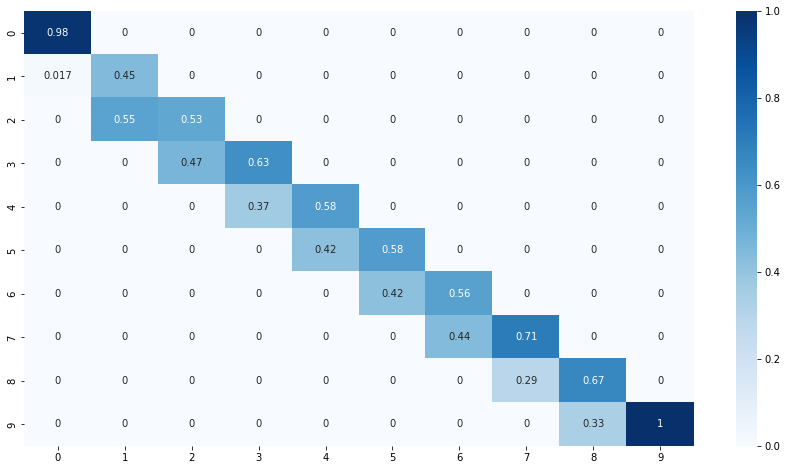

In [324]:
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support, roc_curve, auc, roc_auc_score, precision_recall_curve
from sklearn.preprocessing import normalize

import seaborn as sns
aaax =  list(result['Original'])
baax =  list(result['Prediction'].astype(int))

# aaax =  list(np.array(forDiff_train[3][0]).astype(int))
# baax =  list(np.clip(np.array(forDiff_train[3][1]), 0,9).astype(int))

cf_matrix = confusion_matrix(aaax, baax).astype(int)
k_ = normalize(cf_matrix, axis=0, norm='l1')
ax = sns.heatmap(k_, annot=True, cmap='Blues')
#import cohen_kappa_score
from sklearn.metrics import cohen_kappa_score
cohen_kappa_score(aaax, baax,)
precision_recall_fscore_support(aaax, baax,  average='macro')

In [ ]:
result['diff'].plot.box()
plt.show

In [ ]:
result.groupby(['Prediction']).mean()
X_train

In [ ]:
result